다양한 모델을 결합한 앙상블 학습
- 앙상블 학습
- 다수결 투표를 사용한 분류 앙상블
  - 간단한 다수결 투표 분류기 구현
  - 다수결 투표 방식을 사용하여 예측 만들기
  - 앙상블 분류기의 평가와 튜닝
- 배깅: 부트스트랩 샘플링을 통한 분류 앙상블
  - 배깅 알고리즘의 작동 방식
  - 배깅으로 Wine 데이터셋의 샘플 분류
- 약한 학습기를 이용한 에이다부스트
  - 부스팅 작동 원리
  - 사이킷런에서 에이다부스트 사용
- 그레이디언트 부스팅 – 손실 그레이디언트 기반의 앙상블 훈련
  - 에이다부스트와 그레이디언트 부스팅 비교
  - 그레이디언트 부스팅 알고리즘 소개
  - 분류를 위한 그레이디언트 부스팅 알고리즘
  - 그레이디언트 부스팅 분류 예제
XGBoost 사용하기
- 요약

앙상블 학습

In [2]:
from IPython.display import Image

In [3]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch07/figures/07_01.png', width=500)

In [4]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch07/figures/07_02.png', width=500)

In [5]:
from scipy.special import comb
import math

In [6]:
# 크기가 5인 집합에서 크기가 2인 부분 집합의 수
comb(5,2)

10.0

In [7]:
# n_classifier 앙상블에 포함된 분류기의 수
# error 각 분류기의 오차
def ensemble_error(n_classifier, error):
  k_start = int(math.ceil(n_classifier / 2.))
  probs = [      comb(n_classifier,k)*error**k*(1-error)**(n_classifier-k)  for k in range(k_start,n_classifier+1)  ]
  return sum(probs)

In [8]:
ensemble_error(11,0.25)

0.03432750701904297

In [10]:
import numpy as np
error_range = np.arange(0.0,1.01, 0.01)
print(f"error : {error_range}")
ens_erros = [ ensemble_error(11,error)  for error in error_range]
print(f"앙상블 에러:{ens_erros}")

error : [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
앙상블 에러:[0.0, 4.4254343383479994e-10, 2.71207411810304e-08, 2.957089768150355e-07, 1.5898640480468992e-06, 5.801345058593751e-06, 1.656411575903354e-05, 3.992476631525723e-05, 8.500149873708894e-05, 0.00016459292554947568, 0.0002957060800000002, 0.0004999803724290905, 0.0008039907946370431, 0.001239419514412758, 0.0018430901570849726, 0.0026568635802539054, 0.0037273978509897755, 0.0051057784699690125, 0.0068470276914775734, 0.009009504098156072, 0.011654205440000008, 0.0148

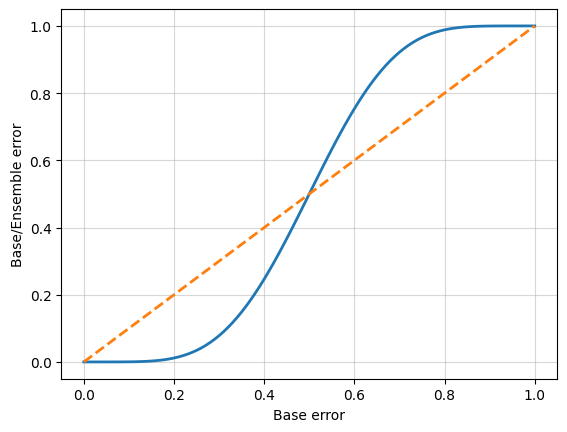

In [11]:
import matplotlib.pyplot as plt
plt.plot(error_range,ens_erros,label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--',label='Base error', linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.grid(alpha=0.5)
plt.show()

다수결 투표를 사용한 분류 앙상블
  - 간단한 다수결 투표 분류기 구현

In [12]:
import numpy as np
np.argmax(np.bincount([0,0,1],weights=[0.2,0.2,0.6] ))

1

In [13]:
np.bincount([0,0,1],weights=[0.2,0.2,0.6] )

array([0.4, 0.6])

In [14]:
ex = np.array([
    [0.9,0.1],
    [0.8,0.2],
    [0.4,0.6]
])
p = np.average(ex,
           axis=0,
           weights=[0.2,0.2,0.6])
p

array([0.58, 0.42])

In [16]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

In [ ]:
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
  def __init__(self,classifiers,vote='classlabel', weights=None) -> None:
    self.classifiers = classifiers,
    self.named_classifiers = { key:value for key, value in _name_estimators(classifiers)}
    self.vote = vote
    self.weights = weights
  def fit(self,X,y):
    if self.vote not in ('probability','classlabel'):
      raise ValueError(f"vote는 'probability or classlabel 이여야 합니다.")
    if self.weights and len(self.weights) != len(self.classifiers):
      raise ValueError(f"분류기와 가중치 개수는 같아야 합니다.")
    # 클래스 레벨은 0부터 시작되어야 하므로 LabelEncoder 를 사용
    self.lablenc_ = LabelEncoder()
    self.lablenc_.fit(y)
    self.classes_ = self.lablenc_.classes_
    self.classifiers_ = []
    for clf in self.classifiers:
      fitted_clf = clone(clf).fit(X , self.lablenc_.transform(y))
      self.classifiers_.append(fitted_clf)
    return self
  # X에 대한 클래스 레이블 예측
  def predict(self,X):
    pass
  # X에 대한 클래스 확률을 예측
  def predict_proba(self,X):
    pass
  # GridSearch 를 위해 분류기의 매개변수 이름을 반환
  def get_params(self, deep=True):
    pass